<a href="https://colab.research.google.com/github/DongMin0000/DeepLearning/blob/main/04_1006_WISDM_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from keras.layers import LSTM

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from google.colab import files
file_uploaded = files.upload()

Saving WISDM.csv to WISDM (2).csv


# 새 섹션

In [7]:
import io
import pandas as pd

data = pd.read_csv(io.BytesIO(file_uploaded['WISDM (2).csv']))

In [8]:
data.isnull().sum()

Unnamed: 0    0
user-id       0
activity      0
timestamp     0
X             0
Y             0
Z             0
dtype: int64

In [9]:
def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
    return numerator / (denominator + 1e-7)

In [10]:
data

,Unnamed: 0,user-id,activity,timestamp,X,Y,Z
0,0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...,...
1098198,1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098199,1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098200,1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098201,1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [11]:
data['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

In [12]:
# Div X, Y

X = data.drop(columns=['activity', 'Unnamed: 0', 'timestamp'], axis=1).values
y = data['activity'].values

Y = pd.get_dummies(y).values

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((878562, 4), (219641, 4), (878562, 6), (219641, 6))

In [15]:
# Create train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=  y_train)

In [16]:
# Reformat the training data into sequence samples
# Source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [17]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

y_val_array = np.array(y_val)
val_set = np.c_[X_val, y_val_array]


# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, 25)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 25)
print(X_test.shape, y_test.shape)

X_val, y_val = split_sequences(val_set, 25)
print(X_val.shape, y_val.shape)

(658897, 25, 9) (658897,)
(219617, 25, 9) (219617,)
(219617, 25, 9) (219617,)


In [18]:
print(X_train.shape, y_train.shape)

(658897, 25, 9) (658897,)


In [19]:
# Convert output variables to categorical for CNN
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

y_val = to_categorical(y_val)
print(y_val.shape)

(658897, 2)
(219617, 2)
(219617, 2)


In [20]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]

[ LSTM(Split_sequences) ]

In [21]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# fit network
train_epochs = 10
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=128, verbose=True,  validation_split=0.2, shuffle = True)

Epoch 1/10
4119/4119 [==============================] - 338s 81ms/step - loss: 0.0285 - accuracy: 0.9853 - val_loss: 8.6300e-09 - val_accuracy: 1.0000
Epoch 2/10
4119/4119 [==============================] - 332s 81ms/step - loss: 4.7918e-04 - accuracy: 0.9998 - val_loss: 4.9648e-08 - val_accuracy: 1.0000
Epoch 3/10
4119/4119 [==============================] - 311s 76ms/step - loss: 6.8348e-06 - accuracy: 1.0000 - val_loss: 1.1398e-10 - val_accuracy: 1.0000
Epoch 4/10
4119/4119 [==============================] - 310s 75ms/step - loss: 3.6069e-04 - accuracy: 0.9999 - val_loss: 4.9551e-08 - val_accuracy: 1.0000
Epoch 5/10
4119/4119 [==============================] - 335s 81ms/step - loss: 3.1128e-06 - accuracy: 1.0000 - val_loss: 2.2796e-10 - val_accuracy: 1.0000
Epoch 6/10
4119/4119 [==============================] - 331s 80ms/step - loss: 2.0012e-04 - accuracy: 1.0000 - val_loss: 1.7352e-08 - val_accuracy: 1.0000
Epoch 7/10
4119/4119 [==============================] - 330s 80ms/step - l

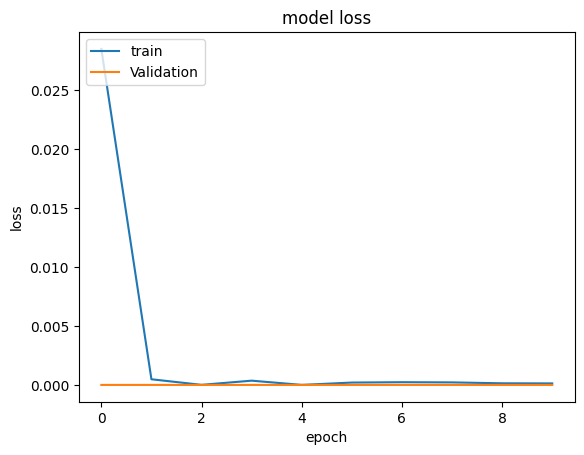

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')